In [ ]:
#Import common libs
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import asarray as arr
import matplotlib.pyplot as plt
import random ,os
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
import math

# Import seaborn for plots
!pip install seaborn
import seaborn as sns

# Import ann_visualizer to visualize neural network
!pip install ann_visualizer 
from ann_visualizer.visualize import ann_viz;

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import acf
from statsmodels.stats.stattools import durbin_watson

%matplotlib inline

#random seed
def seed_everything(seed=666):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything()



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#get the data
f = pd.read_csv("/content/elec_devices_all.csv")
f = f.sort_values(by =['year',"month"]) 

In [ ]:
#melt the data
lis_true =[8418, 8450, 8516, 8421, 8422, 8528, 8531, 8508, 8509, 8414, 8415]
lis_income = [[],[],[],[],[],[],[],[],[],[],[]]
lis_outcome = [[],[],[],[],[],[],[],[],[],[],[]]
#1995 to 2019
for year in range(25):
  for month in range(12):
    for i in range(len(lis_true)):
      df_income  = f.loc[(f['product_code'] == lis_true[i]) & (f['year'] == year+1995) & (f['month'] == month+1) & (f['income_outcome'] == 1)]
      df_outcome = f.loc[(f['product_code'] == lis_true[i]) & (f['year'] == year+1995) & (f['month'] == month+1) & (f['income_outcome'] == 0)]

      if df_income.empty:
        lis_income[i].append(0)
      else:  
        lis_income[i].append(df_income.values[0][3])

      if df_outcome.empty:
        lis_outcome[i].append(0) 
      else:  
        lis_outcome[i].append(df_outcome.values[0][3])    


In [ ]:
#create melt data
df = pd.DataFrame(list(zip(lis_income[0], lis_income[1], lis_income[2], lis_income[3], lis_income[4], lis_income[5], lis_income[6], lis_income[7], lis_income[8], lis_income[9], lis_income[10],
                           lis_outcome[0], lis_outcome[1], lis_outcome[2], lis_outcome[3], lis_outcome[4], lis_outcome[5], lis_outcome[6], lis_outcome[7], lis_outcome[8], lis_outcome[9], lis_outcome[10])), 
               columns =["8418_in", "8450_in", "8516_in", "8421_in", "8422_in", "8528_in", "8531_in", "8508_in", "8509_in", "8414_in", "8415_in",
                         "8418_out", "8450_out", "8516_out", "8421_out", "8422_out", "8528_out", "8531_out", "8508_out", "8509_out", "8414_out", "8415_out"])  

In [ ]:
df = df.iloc[:-1]
df#melted data

8418_in    8450_in    8516_in  ...  8509_out  8414_out  8415_out
0      7661309    4745324    3780457  ...         0         0         0
1      5086199    1763006    2910637  ...      1695      1915         0
2      7600046    4867424    3107025  ...         0      6780     47460
3     12239033    2966894    4516713  ...      6102         0    104755
4      7610380    2275769    3461703  ...         0      1190     12000
..         ...        ...        ...  ...       ...       ...       ...
294  474159015  191703145  124692676  ...   1201818   1401217  65876301
295  436405980  165984139  118857511  ...    569097   1526667  20755897
296  453457777  183964376  127725317  ...   2843273   4463488  17705898
297  396226755  209265685  132923820  ...   2049202   2171420  55985884
298  371499673  162091133  125776395  ...   1087128   6589539  27355204

[299 rows x 22 columns]

In [ ]:
df.to_csv("elec_devices_all_melt.csv", index=False)#save melt data

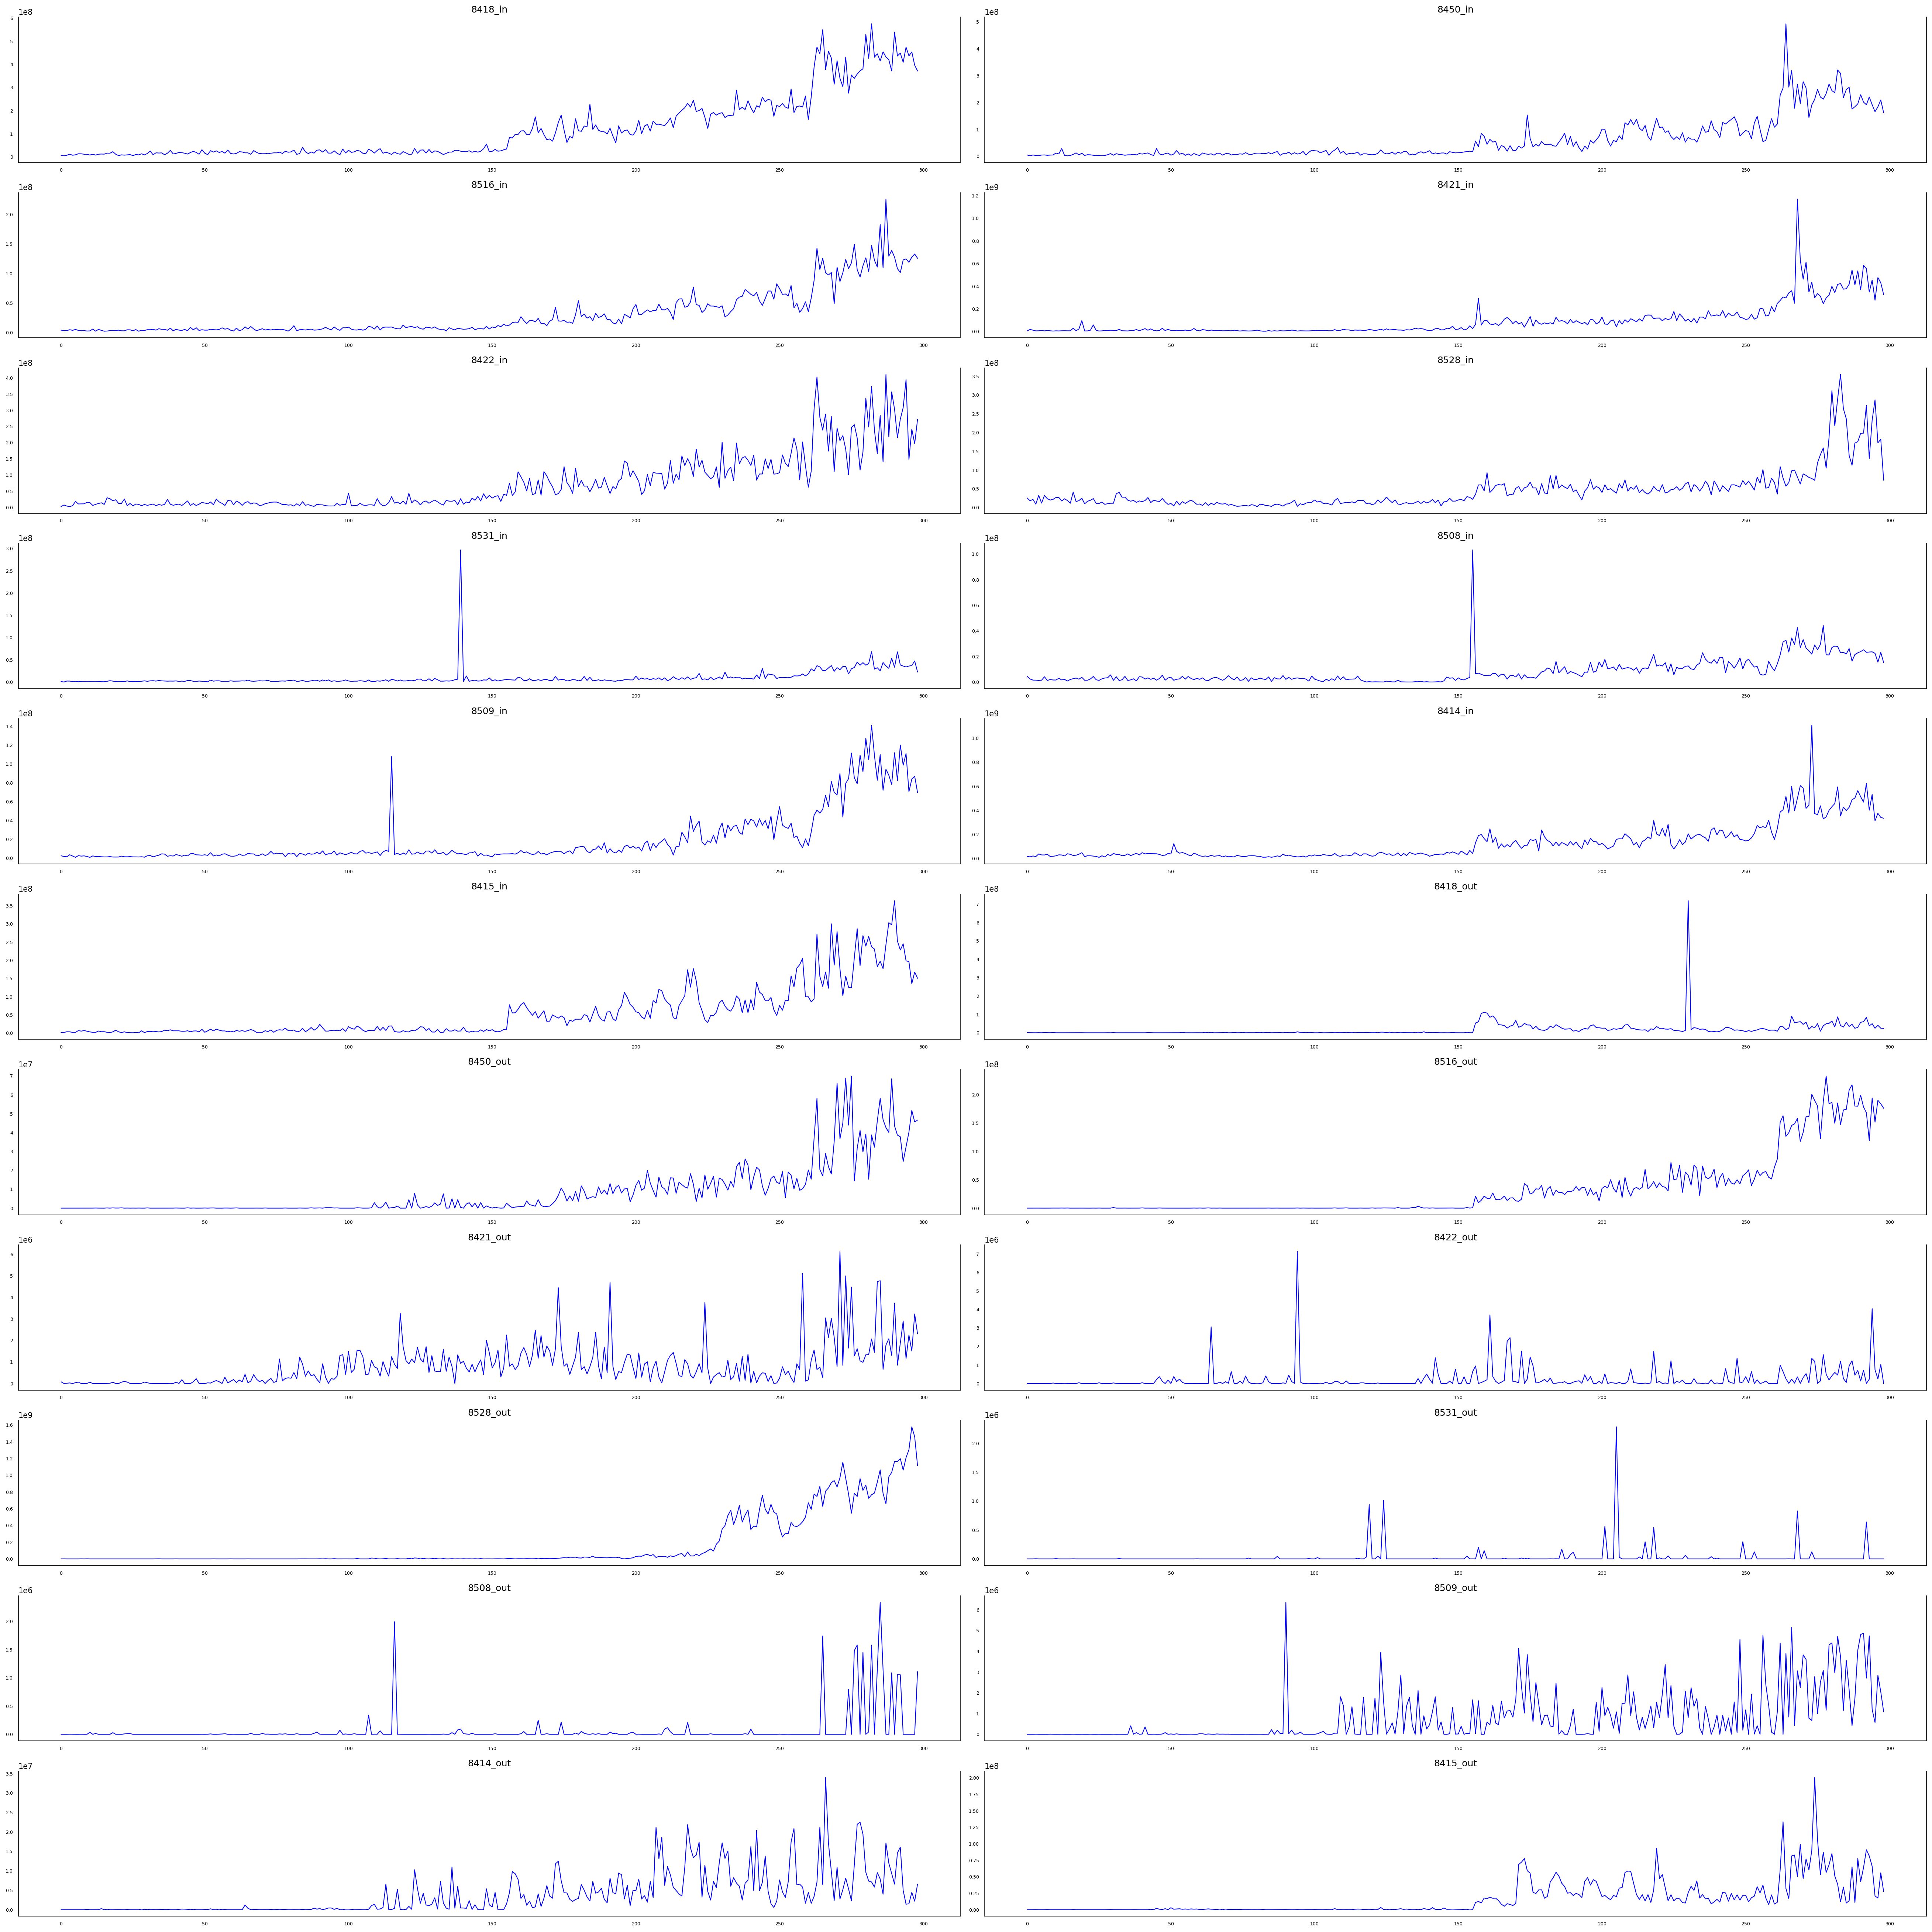

In [ ]:
#show all series
fig, axes = plt.subplots(nrows=11, ncols=2, dpi=150, figsize=(35,35))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
#test
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)   

8418_in_x  8450_in_x  8516_in_x  ...  8509_out_x  8414_out_x  8415_out_x
8418_in_y      1.0000     0.0000     0.0001  ...      0.0034      0.0098      0.0003
8450_in_y      0.0000     1.0000     0.0000  ...      0.0012      0.0202      0.0000
8516_in_y      0.0000     0.0000     1.0000  ...      0.0000      0.0000      0.0000
8421_in_y      0.0000     0.0000     0.0000  ...      0.0000      0.0000      0.0000
8422_in_y      0.0000     0.0000     0.0000  ...      0.0007      0.0009      0.0000
8528_in_y      0.0000     0.0000     0.0000  ...      0.0002      0.0002      0.0000
8531_in_y      0.0000     0.0000     0.0000  ...      0.0000      0.0000      0.0000
8508_in_y      0.0000     0.0000     0.0000  ...      0.0046      0.0004      0.0000
8509_in_y      0.0000     0.0000     0.0000  ...      0.0092      0.0001      0.0000
8414_in_y      0.0000     0.0000     0.0000  ...      0.0015      0.0000      0.0000
8415_in_y      0.0000     0.0000     0.0000  ...      0.0000      0.0000      0.0001
8418_out_y     0.0000     0.0001     0.0001  ...      0.0000      0.0000      0.0002
8450_out_y     0.0000     0.0000     0.0000  ...      0.0000      0.0000      0.0000
8516_out_y     0.0000     0.0000     0.0000  ...      0.0038      0.0000      0.0000
8421_out_y     0.0000     0.0000     0.0000  ...      0.0000      0.0008      0.0000
8422_out_y     0.0008     0.0041     0.0004  ...      0.0000      0.1173      0.0170
8528_out_y     0.0000     0.0000     0.0000  ...      0.0091      0.0000      0.0488
8531_out_y     0.2496     0.0045     0.0029  ...      0.1346      0.1436      0.3411
8508_out_y     0.0000     0.0000     0.0000  ...      0.0001      0.0038      0.0000
8509_out_y     0.0000     0.0000     0.0000  ...      1.0000      0.0000      0.0000
8414_out_y     0.0000     0.0000     0.0000  ...      0.0000      1.0000      0.0000
8415_out_y     0.0000     0.0000     0.0000  ...      0.0001      0.0000      1.0000

[22 rows x 22 columns]

In [ ]:
#Johanson's Cointegration Test
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
8418_in ::  2436.5    > nan       =>   False
8450_in ::  2109.79   > nan       =>   False
8516_in ::  1819.85   > nan       =>   False
8421_in ::  1542.39   > nan       =>   False
8422_in ::  1298.65   > nan       =>   False
8528_in ::  1095.08   > nan       =>   False
8531_in ::  918.6     > nan       =>   False
8508_in ::  765.74    > nan       =>   False
8509_in ::  627.46    > nan       =>   False
8414_in ::  512.94    > nan       =>   False
8415_in ::  428.36    > 311.1288  =>   True
8418_out ::  348.75    > 263.2603  =>   True
8450_out ::  280.1     > 219.4051  =>   True
8516_out ::  224.0     > 179.5199  =>   True
8421_out ::  171.23    > 143.6691  =>   True
8422_out ::  128.79    > 111.7797  =>   True
8528_out ::  93.27     > 83.9383   =>   True
8531_out ::  61.48     > 60.0627   =>   True
8508_out ::  35.35     > 40.1749   =>   False
8509_out ::  17.21     > 24.2761   =>   False
8414_out :

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/vector_ar/vecm.py:608: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  category=HypothesisTestWarning)


In [ ]:
df_train, df_test = df[0:int(299*0.75)], df[int(299*0.75):]
print(df_train.shape) 
print(df_test.shape) 

(224, 22)
(75, 22)


In [ ]:
#adfuller_test for Stationarity
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
        
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [ ]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "8418_in" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.8096
 No. Lags Chosen       = 4
 Critical value 1%     = -3.461
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.9918. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "8450_in" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.9725
 No. Lags Chosen       = 11
 Critical value 1%     = -3.462
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.994. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "8516_in" 
    -----------------------------------------------
 Null Hypothesis: Data has 

In [ ]:
# 1st difference to make Stationarity
df_differenced = df_train.diff().dropna()

In [ ]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "8418_in" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.1298
 No. Lags Chosen       = 3
 Critical value 1%     = -3.461
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "8450_in" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.9164
 No. Lags Chosen       = 9
 Critical value 1%     = -3.461
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "8516_in" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level 

In [ ]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [ ]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "8418_in" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6216
 No. Lags Chosen       = 15
 Critical value 1%     = -3.462
 Critical value 5%     = -2.876
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "8450_in" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.4554
 No. Lags Chosen       = 14
 Critical value 1%     = -3.462
 Critical value 5%     = -2.876
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "8516_in" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

In [ ]:
#brute force to see best lag
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  685.8298328436672
BIC :  693.6102415629794
FPE :  7.233340663351075e+297
HQIC:  688.9714227037497 

Lag Order = 2
AIC :  678.8971518967261
BIC :  694.1684758553117
FPE :  7.892392350240275e+294
HQIC:  685.064115451152 

Lag Order = 3
AIC :  672.5140082775465
BIC :  695.3244727969508
FPE :  1.830194578210439e+292
HQIC:  681.7264833646034 

Lag Order = 4
AIC :  666.1310108663723
BIC :  696.529365604634
FPE :  6.021845596102414e+289
HQIC:  678.4093511331641 

Lag Order = 5
AIC :  659.4960813748711
BIC :  697.5316082750821
FPE :  2.712542961736395e+287
HQIC:  674.860859418339 

Lag Order = 6
AIC :  649.789612674917
BIC :  695.5121340678978
FPE :  1.4332471279666004e+284
HQIC:  668.2616232398517 

Lag Order = 7
AIC :  636.3986566671588
BIC :  689.8585435318813
FPE :  9.756866020643524e+279
HQIC:  657.9989199024204 

Lag Order = 8
AIC :  607.6358071464903
BIC :  668.8839875319813
FPE :  4.1234117490788984e+270
HQIC:  632.385571920682 



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
#select best order
x = model.select_order(maxlags=8)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
#fit model
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 12, Sep, 2020
Time:                     12:13:42
--------------------------------------------------------------------
No. of Equations:         22.0000    BIC:                    696.529
Nobs:                     218.000    HQIC:                   678.409
Log likelihood:          -77455.5    FPE:               6.02185e+289
AIC:                      666.131    Det(Omega_mle):    3.22647e+286
--------------------------------------------------------------------
Results for equation 8418_in
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const         -244457.551930    971186.148416           -0.252           0.801
L1.8418_in         -1.017662         0.100095          -10.167           0.000
L1.8450_in         -0.131979         0.116789           -1.130    

In [ ]:
#simple test:The Durbin Watson (DW) statistic is a test for autocorrelation
def adjust(val, length= 6): return str(val).ljust(length)
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

8418_in : 2.06
8450_in : 2.06
8516_in : 2.15
8421_in : 2.14
8422_in : 2.05
8528_in : 2.08
8531_in : 1.97
8508_in : 2.05
8509_in : 2.21
8414_in : 2.15
8415_in : 2.02
8418_out : 2.08
8450_out : 1.92
8516_out : 2.06
8421_out : 1.91
8422_out : 2.17
8528_out : 2.17
8531_out : 2.18
8508_out : 2.29
8509_out : 2.06
8414_out : 2.17
8415_out : 1.98


In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
print(forecast_input)
forecast_input.shape

4
[[ 4.62138270e+07 -7.36620080e+07  1.76015500e+07 -5.32550000e+06
  -1.87118400e+07  5.29866200e+06  7.83884400e+06  1.00773070e+07
  -4.42814140e+07  9.75900470e+07  9.83107550e+07 -2.56581410e+07
  -1.32369290e+07  1.91585200e+07  4.16276000e+05  1.73022400e+06
   4.60319890e+07  5.62857000e+05  2.07705000e+05 -1.95632800e+06
   3.49922400e+06 -1.09564580e+08]
 [-7.82503690e+07  3.57110320e+07 -5.51765490e+07 -2.40628710e+07
   1.20999387e+08  2.09942420e+07 -1.07025600e+06 -1.74760100e+06
   2.26389690e+07  7.49894030e+07 -8.41770830e+07  1.01312830e+07
  -3.47661100e+06 -1.44957040e+07  4.10860000e+05 -1.67229000e+05
   2.15751480e+07 -3.58340000e+04  0.00000000e+00  1.86855700e+06
   3.14309100e+06  5.28683340e+07]
 [ 5.25945520e+07 -2.12637110e+07  2.87941420e+07  4.42459120e+07
  -1.39803878e+08 -3.91140100e+07  8.20553300e+06  3.51598500e+06
  -1.76019900e+06 -1.28335559e+08 -2.61099820e+07 -4.50282700e+06
   1.60614790e+07  4.51174700e+06  9.02000000e+04  1.36957000e+05
  -3

(4, 22)

In [ ]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=75)
df_forecast = pd.DataFrame(fc, index=df.index[int(299*0.75):], columns=df.columns + '_2d')
df_forecast

8418_in_2d    8450_in_2d  ...   8414_out_2d   8415_out_2d
224 -8.713229e+07 -2.454689e+07  ...  2.220949e+07  1.170852e+07
225  7.712642e+07 -1.686499e+07  ... -3.572856e+06 -1.409737e+07
226  1.062583e+07 -1.083462e+06  ... -2.345143e+07  6.355465e+06
227 -4.609270e+07  5.921397e+07  ...  3.539789e+07  1.304947e+06
228  1.205209e+08 -4.877864e+07  ... -1.993293e+07  4.640169e+07
..            ...           ...  ...           ...           ...
294 -3.830397e+07 -1.764148e+07  ... -6.663825e+06 -7.830739e+05
295  2.737916e+07  2.796041e+07  ...  4.062552e+05 -6.789757e+06
296 -2.348041e+06 -1.836428e+07  ...  3.713102e+06  8.894534e+06
297 -2.319786e+07 -8.330861e+06  ... -1.274096e+06 -6.528782e+06
298  3.870942e+07  3.046335e+07  ... -4.446755e+06  3.363936e+06

[75 rows x 22 columns]

In [ ]:
#invert_transformation of diffrence
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns: 
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


In [ ]:
#results
df_results = invert_transformation(df_train, df_forecast, second_diff=True)      
df_results.loc[:,["8418_in_forecast",	"8450_in_forecast",	"8516_in_forecast","8421_in_forecast",	"8422_in_forecast",	"8528_in_forecast",	"8531_in_forecast",	"8508_in_forecast",	"8509_in_forecast",	"8414_in_forecast",	"8415_in_forecast",
                "8418_out_forecast",	"8450_out_forecast",	"8516_out_forecast",	"8421_out_forecast",	"8422_out_forecast",	"8528_out_forecast",	"8531_out_forecast",	"8508_out_forecast",	"8509_out_forecast",	"8414_out_forecast",	"8415_out_forecast"]]


8418_in_forecast  8450_in_forecast  ...  8414_out_forecast  8415_out_forecast
224      1.316848e+08      7.696002e+07  ...       1.127450e+07       5.371034e+06
225      1.307528e+08      4.200176e+07  ...       1.575301e+07      -1.688783e+07
226      1.404467e+08      5.960049e+06  ...      -3.219905e+06      -3.279122e+07
227      1.040479e+08      2.913230e+07  ...       1.320507e+07      -4.738967e+07
228      1.881700e+08      3.525926e+06  ...       9.697114e+06      -1.558643e+07
..                ...               ...  ...                ...                ...
294     -7.636702e+08     -8.802994e+08  ...      -2.351463e+07      -7.504265e+08
295     -7.704040e+08     -8.805814e+08  ...      -2.569567e+07      -7.674310e+08
296     -7.794860e+08     -8.992276e+08  ...      -2.416360e+07      -7.755410e+08
297     -8.117657e+08     -9.262047e+08  ...      -2.390563e+07      -7.901797e+08
298     -8.053361e+08     -9.227185e+08  ...      -2.809442e+07      -8.014545e+08

[75 rows x 22 columns]

In [ ]:
#Relu
df_results[df_results < 0] = 0

In [ ]:
#evaluation
test=[]
res=[]
for i in df_test.columns:
  test.extend(list(df_test[i].values))
  res.extend(list(df_results[i+"_forecast"].values))
math.sqrt(mean_squared_error(test, res)) #lag 3

200917332.14159206

In [ ]:
data_=DataFrame(test,columns=["y"])

y
0     171609888
1     123453131
2     185158476
3     191893519
4     180951555
...         ...
1645   65876301
1646   20755897
1647   17705898
1648   55985884
1649   27355204

[1650 rows x 1 columns]

Text(0.5, 1.0, 'Residual plot')

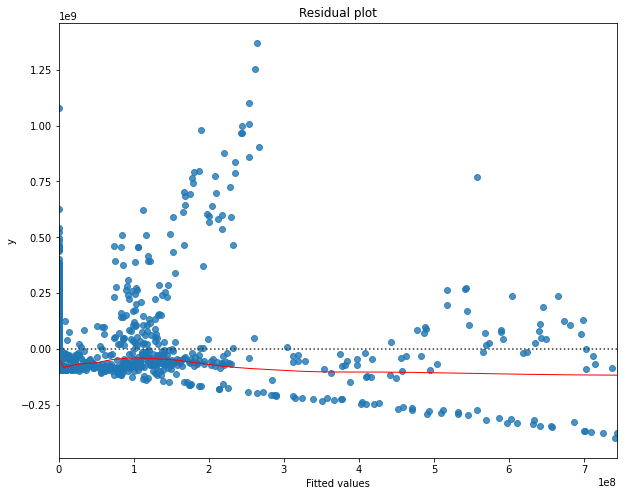

In [ ]:
#Residual plot
plt.figure(figsize=(10,8))
sns.residplot( res ,'y', data=data_[["y"]],lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

Text(0.5, 1.0, 'Normal Q-Q Plot')

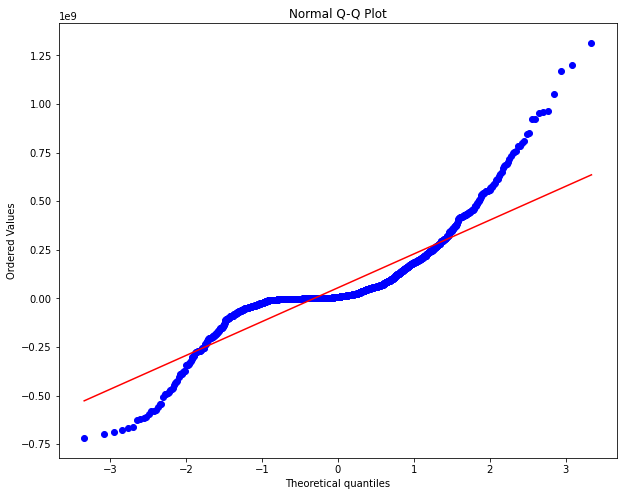

In [ ]:
#Normal Q-Q Plot
preds = pd.DataFrame({"preds": res, "true":data_["y"].values})
residuals= preds["true"] - preds["preds"]
plt.figure(figsize=(10,8))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

Text(0.5, 1.0, 'Scale-Location plot')

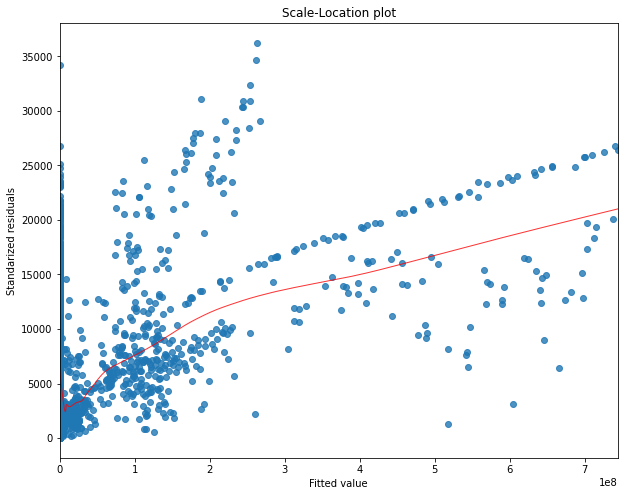

In [ ]:
#Scale-Location plot
model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

plt.figure(figsize=(10,8))
sns.regplot(res, model_norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")
plt.title("Scale-Location plot")

In [ ]:
#forecast vs true
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=250, figsize=(50,50))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
#test func
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = np.mean((forecast - actual)**2)       # MSE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe,'mse':mse, 'rmse':rmse, 'corr':corr, 'minmax':minmax})


In [ ]:
#test
lis_true =[8418, 8450, 8516, 8421, 8422, 8528, 8531, 8508, 8509, 8414, 8415]
for i in lis_true:
  print('Forecast Accuracy of: '+str(i)+"_in")
  accuracy_prod = forecast_accuracy(df_results[str(i)+'_in_forecast'].values, df_test[str(i)+'_in'])
  for k, v in accuracy_prod.items():
      print(adjust(k), ': ', round(v,4))
sum=[]     
for i in lis_true:
  print('Forecast Accuracy of: '+str(i)+"_out")
  accuracy_prod = forecast_accuracy(df_results[str(i)+'_out_forecast'].values, df_test[str(i)+'_out'])
  for k, v in accuracy_prod.items():
      print(adjust(k), ': ', round(v,4))
      sum.append(accuracy_prod["mse"])
      
np.mean(sum)

Forecast Accuracy of: 8418_in
mape   :  0.5214
me     :  -24147838.3208
mae    :  174511632.6911
mpe    :  -0.012
mse    :  6.236963830865999e+16
rmse   :  249739140.522
corr   :  0.2688
minmax :  0.408
Forecast Accuracy of: 8450_in
mape   :  0.958
me     :  -157534728.9477
mae    :  159192736.0959
mpe    :  -0.9331
mse    :  3.283743882582841e+16
rmse   :  181211033.9517
corr   :  -0.2283
minmax :  0.9538
Forecast Accuracy of: 8516_in
mape   :  0.5184
me     :  -40724521.8184
mae    :  48475156.599
mpe    :  -0.3726
mse    :  4315474309405127.0
rmse   :  65692269.7842
corr   :  0.1909
minmax :  0.4942
Forecast Accuracy of: 8421_in
mape   :  0.8829
me     :  -147607991.5632
mae    :  252616476.058
mpe    :  -0.5333
mse    :  1.0822709075551405e+17
rmse   :  328978860.6514
corr   :  0.2284
minmax :  0.7824
Forecast Accuracy of: 8422_in
mape   :  0.9126
me     :  -146241291.995
mae    :  169667812.2988
mpe    :  -0.8257
mse    :  3.790492001085639e+16
rmse   :  194691859.1284
corr   :  0

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


2.0362026759041852e+16

#Neural Network

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
f = pd.read_csv("/content/elec_devices_all.csv")
f = f.sort_values(by =['year',"month"]) 
data_=DataFrame(f)
# split into input (X) and output (Y) variables
X_train ,Y =f[['year',"month","product_code","income_outcome"]] ,f[['y']]
X_Train=X_train.values
X_Train=np.asarray(X_Train)

x_train , y , x_test, y_test = X_Train[0:int(5766*0.75)] ,Y[0:int(5766*0.75)] ,X_Train[int(5766*0.75):] ,Y[int(5766*0.75):]

In [ ]:
#standrize 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
# Regression Example With Boston Dataset: Standardized
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
# load dataset

# define base model
def baseline_model():
	# create model
 model = Sequential()
 model.add(Dense(25, input_dim=4, kernel_initializer='normal', activation='relu'))
 model.add(Dense(100, kernel_initializer='normal', activation='relu'))
 model.add(Dense(200, kernel_initializer='normal', activation='relu'))
 model.add(Dense(100, kernel_initializer='normal', activation='relu'))
 model.add(Dense(150, kernel_initializer='normal', activation='relu'))
 model.add(Dense(250, kernel_initializer='normal', activation='relu'))
 model.add(Dense(250, kernel_initializer='normal', activation='relu'))
 model.add(Dense(250, kernel_initializer='normal', activation='relu'))
 model.add(Dense(150, kernel_initializer='normal', activation='relu'))
 model.add(Dense(100, kernel_initializer='normal', activation='relu'))
 model.add(Dense(50, kernel_initializer='normal', activation='relu'))
 model.add(Dense(10, kernel_initializer='normal', activation='relu'))
 model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
 model.compile(loss='mean_squared_error', optimizer='adam')
 return model
# evaluate model with standardized dataset

model =baseline_model()
model.fit(x_train, y, epochs=150,batch_size=1, verbose=1)


Epoch 1/150
4324/4324 [==============================] - 9s 2ms/step - loss: 552964255121408.0000
Epoch 2/150
4324/4324 [==============================] - 9s 2ms/step - loss: 463964580347904.0000
Epoch 3/150
4324/4324 [==============================] - 9s 2ms/step - loss: 500258161295360.0000
Epoch 4/150
4324/4324 [==============================] - 9s 2ms/step - loss: 505902855618560.0000
Epoch 5/150
4324/4324 [==============================] - 9s 2ms/step - loss: 428638742773760.0000
Epoch 6/150
4324/4324 [==============================] - 9s 2ms/step - loss: 455729248993280.0000
Epoch 7/150
4324/4324 [==============================] - 9s 2ms/step - loss: 422118344884224.0000
Epoch 8/150
4324/4324 [==============================] - 9s 2ms/step - loss: 405104771465216.0000
Epoch 9/150
4324/4324 [==============================] - 9s 2ms/step - loss: 434898523389952.0000
Epoch 10/150
4324/4324 [==============================] - 9s 2ms/step - loss: 407621957844992.0000
Epoch 11/150
4324/4

In [ ]:
ann_viz(model, title="Regression Neural Network")

In [ ]:
#predict
pre=model.predict(x_test)

In [ ]:
#evaluate
print(math.sqrt(mean_squared_error(y_test, pre)))
print(math.sqrt(mean_squared_error(y, model.predict(x_train))))

175647859.8089044
16161590.61229031


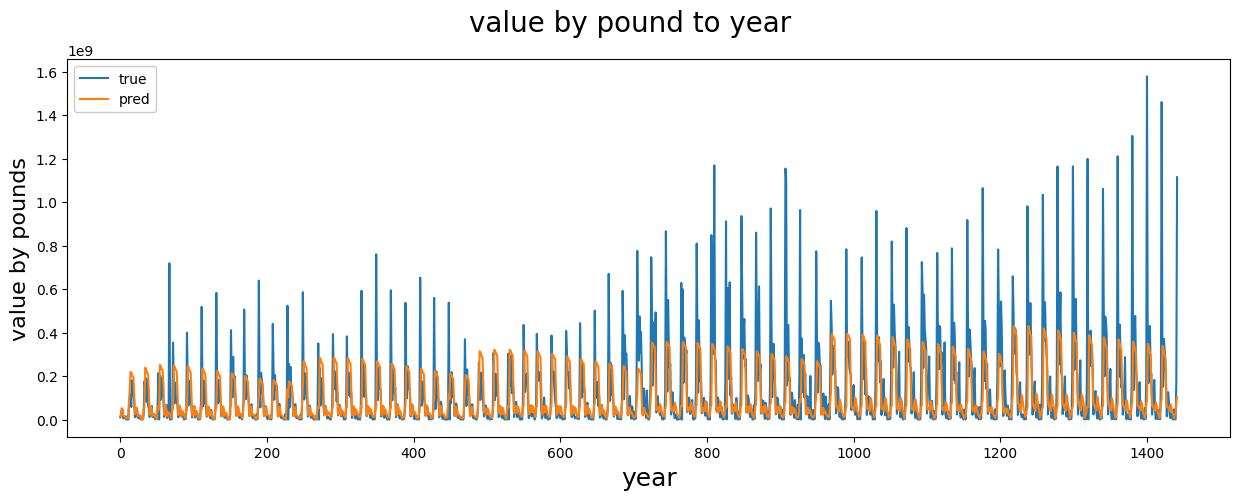

In [ ]:
#true vs pred
store_list = ["true","pred"]
  #mm=data.loc[data['income_outcome'] == 0]
plt.plot(np.array(y_test), label=store_list[0])
plt.plot(pre, label=store_list[1])
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100
plt.suptitle('value by pound to year', fontsize=20)
plt.xlabel('year', fontsize=18)
plt.ylabel('value by pounds', fontsize=16)
plt.legend(framealpha=1, frameon=True);

Text(0.5, 1.0, 'Residual plot')

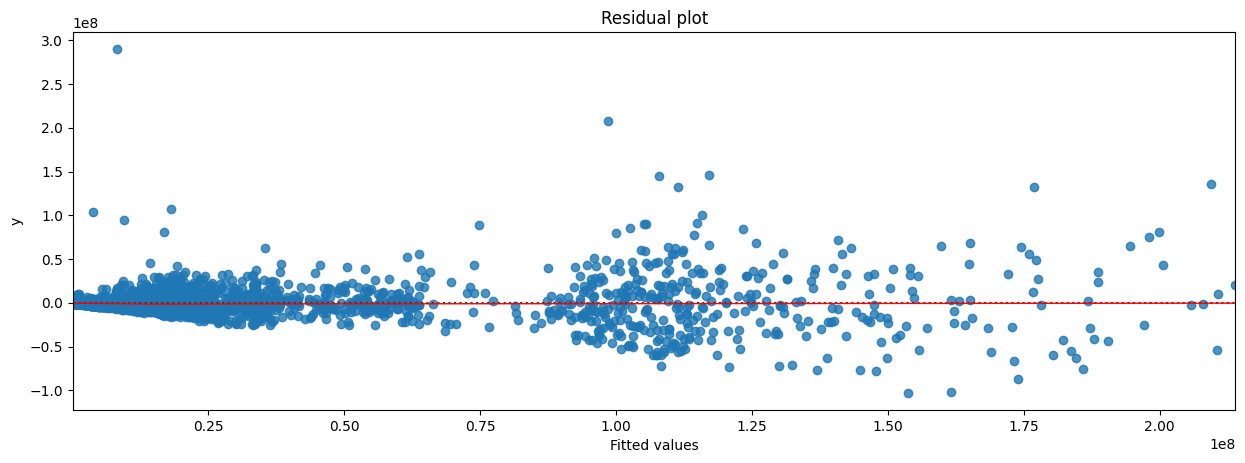

In [ ]:
sns.residplot( np.array(model.predict(x_train).reshape((5766-1442))) ,'y', data=data_[["year","month",'product_code',"income_outcome","y"]][:int(5766*0.75)],lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

Text(0.5, 1.0, 'Normal Q-Q Plot')

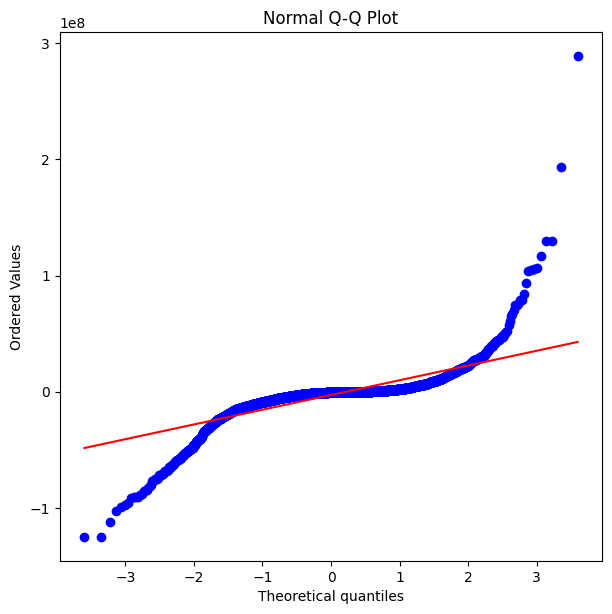

In [ ]:

preds = pd.DataFrame({"preds": np.array(model.predict(x_train).reshape((5766-1442))), "true":y["y"].values})
residuals= preds["true"] - preds["preds"]
plt.figure(figsize=(7,7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

Text(0.5, 1.0, 'Scale-Location plot')

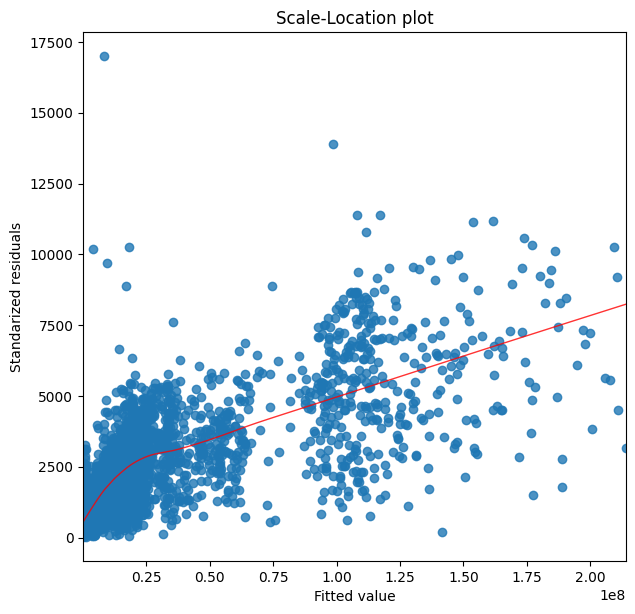

In [ ]:
model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

plt.figure(figsize=(7,7))
sns.regplot(np.array(model.predict(x_train).reshape((5766-1442))), model_norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")
plt.title("Scale-Location plot")